In [1]:
import os
import random
import itertools

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# データ読み込み

## 臨床データの読み込み

先に1.0-EDA_clinicalを実行すること

In [2]:
df_clinical = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

## 遺伝子データの読み込み

In [3]:
# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# 　ファイルの中身が壊れているため、使用するなら要修正
# df_mutations = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_mutations.txt").T


# 各dfの中身変更防止の為setを仕様
df_set = (
    df_cna,
    df_methylation_promoters_rrbs,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    df_mrna_agilent_microarray,
    # df_mutations
)
df_name_set = (
    "df_cna",
    "df_methylation_promoters_rrbs",
    "df_mrna_agilent_microarray_zscores_ref_all_samples",
    "df_mrna_agilent_microarray",
    # "df_mutations"
)

# 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

## 目的変数｜5,10,15年後の予後の2値分類
5,10,15年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [4]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [5]:
def make_target(df: pd.DataFrame(), year: int = 5, drop=False):
    df = df.copy()  # 引数dfの更新を防ぐ（pythonの関数は参照渡し）
    target_name = "OS_" + str(year) + "years"
    df[target_name] = np.nan
    df[target_name] = df[target_name].mask(df["OS_MONTHS"] > year * 12, False)
    df[target_name] = df[target_name].mask(
        (df["OS_MONTHS"] <= year * 12) & (df["VITAL_STATUS"] == "Died of Disease"),
        True,
    )
    # targetを定義できなかったデータは除く
    if drop:
        df = df[df[target_name].notnull()]
    return df

In [6]:
df_MB = make_target(df_MB, year=5)
df_MB = make_target(df_MB, year=10)
df_MB = make_target(df_MB, year=15)
target_list = ["OS_5years", "OS_10years", "OS_15years"]

# データフレームの結合

臨床データと遺伝子データを結合する  
結合パターン
1. 臨床データと生の遺伝子発現データ
2. 臨床データとzスコア化した遺伝子発現データ
3. 臨床データとzスコア化（2倍体）した遺伝子発現データ


## データフレームの結合
### 使用する特徴量

臨床データ
- 目的変数：OS_nyears
- 遺伝子学的特徴量：CLAUDIN_SUBTYPE

遺伝子発現データ
- 全ての遺伝子発現

In [7]:
df_cross = (
    pd.merge(
        df_MB[
            ["PATIENT_ID", "OS_5years", "OS_10years", "OS_15years", "CLAUDIN_SUBTYPE"]
        ],
        df_mrna_agilent_microarray,
        left_on="PATIENT_ID",
        right_index=True,
        how="inner",
    )
    .reset_index(drop=True)
    .drop("PATIENT_ID", axis=1)
)
df_cross.tail()

,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1899,False,False,False,LumA,8.589374,6.002483,5.116077,4.996112,5.802742,5.474550,8.251690,5.373561,5.546402,6.532649,5.535139,6.282020,5.440358,5.637957,5.172188,6.486128,6.074573,5.281556,6.058330,8.722802,5.891944,...,5.394435,5.324246,6.132406,5.471503,5.372043,5.364380,8.455392,10.303605,6.686198,9.987552,5.354638,5.529167,5.722099,5.240904,5.521765,5.488675,5.461927,7.536208,8.314500,5.337300,6.278034,5.426899,6.923887,5.251896,5.168953
1900,True,True,True,LumB,8.402660,6.104059,5.443955,5.224513,5.256086,6.659117,8.641838,5.488370,5.522964,7.102716,5.353956,5.546199,5.289827,5.272168,5.424468,6.491748,5.865518,5.564988,6.132467,8.814733,6.236368,...,5.304696,5.396539,6.221306,5.315972,5.300309,5.268524,8.523291,11.353435,6.623708,8.441388,5.443857,5.644035,5.453321,5.171671,5.441341,5.375910,5.393811,7.709596,8.105717,5.397931,6.325456,5.217163,6.524268,5.505418,5.252479
1901,False,False,True,LumB,8.236918,5.402870,5.533742,5.468793,5.571897,5.439574,8.979375,5.283460,5.804127,6.593890,5.353883,5.705768,5.531300,5.313886,5.212158,6.906297,6.116738,5.132988,6.031882,8.530870,5.744546,...,5.466731,5.291783,7.066555,5.382979,5.550651,5.335161,8.286103,10.428968,6.769603,6.564861,5.591439,5.597712,5.334787,5.182920,5.339665,5.487068,5.406575,7.729912,7.944622,5.412713,6.254337,5.405552,6.121864,5.462270,5.357823
1902,False,NaN,NaN,LumB,8.376571,5.617954,5.375647,5.305559,5.631592,5.734358,8.628511,5.232599,5.472525,6.175189,5.473054,5.963092,5.308848,5.491198,5.050838,6.507257,5.484692,5.355723,6.003971,9.396055,5.921776,...,5.294014,5.389626,6.250953,5.489047,5.725481,5.382300,8.473675,10.452393,6.571327,7.323750,5.334621,5.560818,5.406241,5.351516,5.361063,5.214711,5.689935,7.329023,8.348807,5.474224,6.415853,5.344851,7.029076,5.519022,5.512290
1903,False,False,False,LumB,9.283964,7.137196,5.221194,5.549350,5.462977,5.222914,8.251690,5.365380,5.660058,6.683335,5.327812,5.818325,5.066311,5.361826,5.256033,6.292127,5.387614,5.342313,5.983110,8.883370,6.408964,...,5.281974,5.253435,6.125892,5.466416,5.467026,5.384024,8.202645,10.394254,6.886155,8.423223,5.312663,5.772291,5.646755,5.479193,5.709304,5.227597,5.382574,7.763496,8.053959,5.238813,6.898575,5.353198,6.769960,5.464610,5.232599


### 重複カラムのリネーム
有識者の意見：重複した遺伝子発現は別の遺伝子発現として扱うべき。


In [8]:
# 重複特徴量の確認
print("重複特徴量")
print(df_cross.columns[df_cross.columns.duplicated()].value_counts())
# 重複特徴量のrename
df_cross = rename_duplicated_columns(df_cross)
# 重複特徴量の確認
print("重複特徴量（rename後確認）")
print(df_cross.columns[df_cross.columns.duplicated()].value_counts())

重複特徴量
TRDV2        6
RPL13A       5
IL23A        4
WASH3P       3
LINC00965    2
            ..
LSP1         1
CLK2         1
TNRC18       1
KPNA2        1
C4orf50      1
Length: 168, dtype: int64
重複特徴量（rename後確認）
Series([], dtype: int64)


# 欠損値データの処理

### OS_5yearsが欠損しているデータの削除

In [9]:
df_cross = df_cross[df_cross["OS_5years"].notnull()]

In [10]:
df_cross.shape

(1757, 24372)

### 遺伝子発現の欠損値の確認

In [11]:
df_tmp = df_cross.isnull().sum().sort_values()[::-1]
df_tmp = df_tmp[df_tmp.values > 0]

In [12]:
df_tmp

OS_15years    679
OS_10years    348
CSNK2A1         2
SLC25A19        2
TMPRSS7         1
AK127905        1
IDO1            1
BAMBI           1
FAM71A          1
dtype: int64

In [13]:
display(df_cross[df_cross["SLC25A19"].isnull()])
display(df_cross[df_cross["CSNK2A1"].isnull()])
display(df_cross[df_cross["AK127905"].isnull()])
display(df_cross[df_cross["TMPRSS7"].isnull()])
display(df_cross[df_cross["IDO1"].isnull()])
display(df_cross[df_cross["BAMBI"].isnull()])
display(df_cross[df_cross["FAM71A"].isnull()])

,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
486,False,False,False,LumA,8.752832,6.728878,5.265908,5.428122,6.011156,8.695291,8.466168,5.267247,5.407875,5.680328,5.418472,6.566780,5.445005,5.338215,5.158566,5.980846,5.835921,5.387767,6.127834,9.070367,6.116849,...,5.421358,5.427568,5.731478,5.259431,5.285398,5.191198,8.241863,10.777161,6.990013,8.236918,5.288145,5.567312,5.562634,5.549441,5.613648,5.697380,5.561457,6.658756,8.767993,5.182273,6.511633,5.256083,7.874376,5.462590,5.236271
1651,False,False,NaN,Her2,8.298668,6.186827,5.266570,5.254843,6.242823,5.522508,8.389472,4.998942,5.611558,6.211793,5.551609,5.234407,5.509162,5.590460,5.248835,6.445314,7.308816,5.385550,6.218572,9.087248,6.282904,...,5.248726,5.384832,6.912935,5.548605,5.337198,5.397305,7.924804,10.507321,6.556178,7.054271,5.471377,6.337595,5.696034,5.612112,5.294910,5.132331,5.291950,7.248749,8.705246,5.539829,6.291565,5.464605,7.602547,5.368716,5.316522


,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
718,False,False,False,Her2,8.983845,6.154832,5.463275,5.140800,5.762100,5.575108,8.366148,5.213441,5.480032,6.094584,5.539119,5.995259,5.490708,5.525184,5.517009,6.715420,5.626920,5.271677,6.252703,9.599483,6.219926,...,5.163662,5.487514,6.888481,5.603110,5.407872,5.257659,7.535728,11.197757,6.335867,8.407267,5.473802,5.976417,5.230611,5.393206,5.589352,5.262591,5.499623,7.690986,8.334724,5.433179,6.366907,5.374074,6.276341,5.233092,5.127081
1658,False,NaN,NaN,LumB,8.809021,6.490103,5.502013,5.716855,5.671855,5.315538,8.387535,5.711542,5.535965,7.798269,5.490895,5.672131,5.408700,5.338358,5.129173,5.878103,6.915673,5.466695,5.711715,8.630528,6.869970,...,5.242368,5.276341,6.309263,5.618022,5.406522,5.197122,7.924265,10.707883,6.680489,7.651638,5.197415,6.425573,5.474114,5.481945,5.467659,5.644017,5.478255,7.114368,8.847109,5.222065,6.350829,5.286291,6.608030,5.476758,5.570788


,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
7,False,NaN,NaN,claudin-low,8.436053,5.845972,5.429151,5.462739,5.796744,9.513015,8.955945,5.270376,5.566713,6.258003,5.27322,7.257667,5.299815,5.328303,5.370871,6.250129,5.567929,5.617658,5.666111,7.281997,6.237218,...,5.335976,5.480618,5.675537,5.56352,5.420137,5.335642,7.826649,9.959284,7.298256,7.765512,5.594321,5.681154,5.687635,5.496705,5.256771,5.528183,5.556035,7.311774,7.506798,5.336678,6.040794,5.069086,5.909208,5.447886,5.493015


,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
140,False,True,True,claudin-low,8.721524,5.500859,5.521834,5.236688,5.533894,6.683335,7.50078,5.202739,5.722302,7.988028,6.182807,5.668817,5.382574,5.202969,5.139063,5.961513,5.551212,5.153493,6.379514,9.508277,6.140016,...,5.177635,5.20413,6.162613,5.48822,5.461181,5.252583,7.521205,10.118382,6.49044,10.160884,5.341439,5.910113,5.622522,5.501713,5.565144,5.740884,5.074019,7.725871,8.411298,6.090043,6.20853,5.180896,7.442164,5.326259,5.309085


,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1814,False,False,NaN,LumA,9.208431,6.120859,5.480815,5.094417,5.885308,6.954527,8.813915,5.171671,5.57697,6.018173,5.481612,6.282845,5.274408,5.491235,5.185381,6.833276,5.79483,5.296329,6.129174,9.220519,6.635205,...,5.335236,5.583297,6.12615,4.905798,5.266572,5.716686,8.333421,10.532636,7.14226,7.432982,5.474933,6.171326,5.616832,5.669589,5.446446,5.660212,5.578895,6.88075,7.749458,5.380891,6.092204,5.548796,6.204183,5.376818,5.101745


,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
931,False,False,False,LumA,9.894345,6.974026,5.299079,5.390438,6.088596,7.719513,8.55072,5.501831,5.596242,5.814905,5.370253,5.82107,5.20519,5.460944,5.313886,6.522952,5.593119,5.488904,6.055636,10.070369,7.170337,...,5.215902,5.404746,5.904526,5.63052,5.335327,5.58744,8.180081,10.85873,6.838932,8.35656,5.433383,6.649169,5.558321,5.431659,5.643799,5.675376,5.410839,7.602045,7.986372,5.189304,6.893133,5.413542,7.671213,5.355344,5.384797


,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1511,False,False,True,LumA,9.191999,7.310023,5.395278,5.245195,5.863245,8.358453,8.36361,5.521382,5.556221,6.382908,5.195393,5.973981,5.416195,5.298888,5.172999,6.471618,5.937527,5.270634,6.273167,9.797347,6.798067,...,5.36207,5.306782,6.048051,5.432537,5.294563,5.31487,7.837516,11.040323,6.623371,8.809021,5.282792,5.893495,5.742766,5.464505,5.318898,5.334076,5.531901,7.619821,8.231978,5.354479,6.109259,5.463444,7.591419,5.283728,NaN


インデックスは全て異なる

遺伝子発現に欠損を含むデータの削除

In [14]:
df_cross = df_cross[df_cross["SLC25A19"].notnull()]
df_cross = df_cross[df_cross["CSNK2A1"].notnull()]
df_cross = df_cross[df_cross["AK127905"].notnull()]
df_cross = df_cross[df_cross["TMPRSS7"].notnull()]
df_cross = df_cross[df_cross["IDO1"].notnull()]
df_cross = df_cross[df_cross["BAMBI"].notnull()]
df_cross = df_cross[df_cross["FAM71A"].notnull()]
df_cross.shape

(1748, 24372)

# 特徴量選択

filter method

- χ^2検定
- ANOVA
- Mutual information

## データセットの分割
trainデータとtestデータに分割  
testデータは訓練には用いない（学習終了後の性能の確認のみ）

trainデータとtestデータを分割した場合の、分布の確認

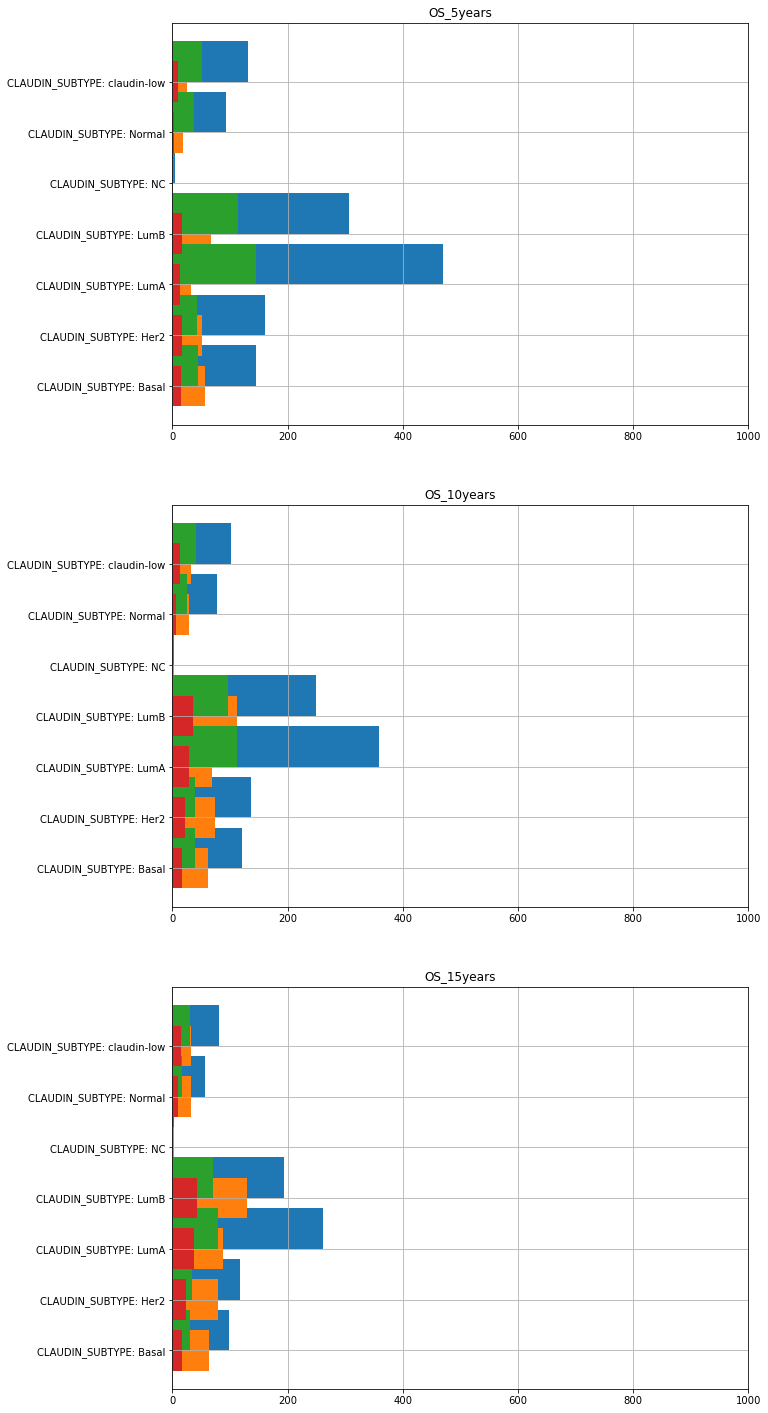

In [16]:
df_train, df_test = train_test_split(df_cross, random_state=SEED)

plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    # trai
    df_tmp = df_train.groupby("CLAUDIN_SUBTYPE")[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = "CLAUDIN_SUBTYPE: " + df_tmp["CLAUDIN_SUBTYPE"]
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])

    # test
    df_tmp = df_test.groupby("CLAUDIN_SUBTYPE")[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = "CLAUDIN_SUBTYPE: " + df_tmp["CLAUDIN_SUBTYPE"]
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])

    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 1000)

    plt.grid(True)

大まかにはtrain,testのデータ量の比率は大丈夫そう

数の少ないNCについては確認

In [17]:
df_train[df_train["CLAUDIN_SUBTYPE"] == "NC"]

,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
803,False,True,True,NC,9.232775,5.684506,5.549272,5.229785,7.135959,5.574847,7.239234,5.610583,5.712039,6.555837,5.380589,5.891009,5.403241,5.611992,5.493431,5.640751,5.378960,5.457948,6.668552,9.834888,8.687667,...,4.942155,5.402007,5.257030,5.632073,5.576194,5.146395,7.829231,12.330379,6.489781,7.253072,5.183949,7.282830,6.313969,5.444530,5.798916,5.489539,5.430857,9.266545,7.986918,5.447164,7.244882,5.219696,6.251790,5.395806,5.495293
1858,True,True,True,NC,9.145344,5.693430,5.247809,5.487468,5.905418,9.682270,8.241262,5.173806,5.600204,6.402999,5.499857,5.848234,5.469991,5.622124,5.282562,6.466090,6.157855,5.263349,6.039950,8.973335,7.295681,...,5.210486,5.404015,6.661604,5.380589,5.665482,5.318350,8.456725,10.538381,6.419921,9.818465,5.604104,5.696594,5.625684,5.416062,5.543376,5.231852,5.288600,7.427494,8.140274,5.242993,5.957265,5.430206,6.500926,5.314402,5.102854
926,False,NaN,NaN,NC,9.375749,6.805984,5.512144,5.203031,6.006168,9.925118,9.003693,5.230243,5.675869,6.563520,5.196793,6.444020,5.495824,5.450528,5.594094,6.136965,5.739226,5.175794,6.030502,9.535611,7.263929,...,5.152642,5.471858,5.924224,5.223516,5.336431,5.275628,8.104001,11.076031,6.758905,8.953343,5.627411,5.998360,5.489234,5.500631,5.444427,5.290177,5.331632,7.803960,7.913550,5.230487,6.400798,5.347453,6.515638,5.450356,4.948689
533,False,False,False,NC,8.746475,6.236368,5.190039,5.370501,5.879293,5.603518,8.365536,5.399194,5.519185,6.067197,5.385871,6.609433,5.334152,5.520260,5.255074,6.152495,6.090777,5.256276,6.038869,9.334087,6.212881,...,5.232662,5.222655,6.505239,5.488750,5.405459,5.342856,8.153666,10.219242,6.506232,9.630245,5.202284,5.669465,5.722818,5.510159,5.347605,5.589518,5.556605,7.464064,8.399333,5.248618,5.851315,5.371495,7.762986,5.306048,5.454326


In [18]:
df_test[df_test["CLAUDIN_SUBTYPE"] == "NC"]

,OS_5years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1302,False,False,False,NC,9.540285,6.874232,5.256893,5.380006,6.012681,5.924414,8.091861,5.256086,5.625752,6.710375,5.396173,5.624752,5.318313,5.460340,5.245090,5.539649,7.104079,5.352159,6.606179,10.419544,6.864178,...,5.068038,5.473636,5.784465,5.591020,5.631688,5.474550,8.127024,10.960146,6.730685,9.577290,5.662672,5.631670,5.618781,5.463764,5.523588,5.528654,5.327963,7.088676,8.287344,5.390791,6.708604,5.421290,7.181684,5.423229,5.330702
1542,False,False,NaN,NC,9.260052,6.762604,5.332223,5.351526,6.388192,8.587925,7.481390,5.454708,5.603289,6.255192,5.316599,5.715155,5.469240,5.489841,5.175385,5.924962,5.788998,7.624685,6.360152,9.916234,7.931711,...,5.275678,5.320989,5.827177,5.707003,5.981490,5.318664,7.784967,11.685759,6.356845,7.962407,5.267513,6.051745,5.197040,5.257659,5.481906,5.803853,5.581225,8.162512,7.521205,6.156114,6.088364,5.319071,6.655234,5.234130,5.039263


testデータにはFalseの事例しか無く、また、交差検証をする際に十分に学習できる見込みがない  
▷NCのデータも削除したほうが良い

In [19]:
df_cross = df_cross[df_cross["CLAUDIN_SUBTYPE"] != "NC"]

In [36]:
y5 = df_cross["OS_5years"]
y10 = df_cross["OS_10years"]
y15 = df_cross["OS_15years"]
X = df_cross.drop(["OS_5years", "OS_10years", "OS_15years"], axis=1)
X_train, X_test, y5_train, y5_test = train_test_split(X, y5, random_state=SEED)
X_train, X_test, y10_train, y10_test = train_test_split(X, y10, random_state=SEED)
X_train, X_test, y15_train, y15_test = train_test_split(X, y15, random_state=SEED)

# save
make_dir(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR)

df_cross.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
)
X.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X.pkl")
X_train.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_train.pkl"
)
X_test.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_test.pkl")
y5.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y.pkl")
y5_train.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y5_train.pkl"
)
y5_test.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y5_test.pkl"
)
y10.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y10.pkl")
y10_train.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y10_train.pkl"
)
y10_test.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y10_test.pkl"
)
y15.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y15.pkl")
y15_train.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y15_train.pkl"
)
y15_test.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y15_test.pkl"
)

In [22]:
X_train.head()

,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CR749394,CD164,DB337918,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1215,Basal,9.311580,7.744317,5.554126,5.263782,5.868320,5.998904,8.098483,5.320854,5.566427,6.298859,6.642198,5.320670,5.490522,5.342145,5.373195,5.980949,5.908109,5.322594,6.045390,9.042283,7.034465,5.379395,5.282418,5.325543,...,5.199058,5.296325,6.467451,5.729199,5.372313,5.314294,8.223501,10.786531,6.948090,7.074794,5.430225,6.074347,5.379935,5.518892,5.487863,6.695047,5.479791,7.704394,8.341997,5.363884,6.519977,5.100848,6.813718,5.473572,5.442110
1323,LumA,9.363547,6.208161,5.555838,5.201139,6.283917,5.324560,8.270480,5.290929,5.645739,6.503370,5.249774,5.674939,5.441643,5.469529,5.058382,5.968082,6.011519,5.349533,6.401689,9.539876,7.207997,5.382562,5.861760,5.393921,...,5.183643,5.373881,6.091925,5.316944,5.306277,5.382030,8.499930,10.939880,6.685701,8.667317,5.464050,5.956127,5.700199,5.248050,5.305654,5.360366,5.357576,7.590759,7.395544,5.214577,6.145482,5.261043,6.582466,4.952319,5.173312
662,LumA,9.601747,6.688510,5.553430,5.532417,6.139435,6.112157,9.065875,5.273341,5.592448,6.158989,5.242269,5.556625,5.381293,5.391029,5.521394,5.912070,5.883122,5.449520,6.303169,9.192849,6.305275,5.305837,6.105803,5.427378,...,5.530883,5.454663,5.884662,5.335396,5.458799,5.058954,7.661084,9.947258,7.181043,9.644412,5.490010,5.664893,5.539601,5.468645,5.545868,5.573837,5.279494,8.130347,7.790644,5.207923,6.050002,5.450757,7.381971,5.325568,5.222716
507,LumA,9.525949,6.639349,5.195991,5.270236,6.312787,8.311320,8.243734,5.402541,5.349292,6.445639,5.179642,6.541230,5.389758,5.433715,5.209243,5.975464,5.112070,5.498790,6.510332,10.136744,6.673411,5.489470,6.883094,5.344071,...,5.335386,5.276573,5.628650,5.436958,5.548103,5.576866,8.425177,11.390290,6.607323,8.128185,5.535837,5.807994,5.632878,5.288023,5.174007,5.584151,5.428407,7.525444,7.678626,5.564841,6.177820,5.399758,6.711463,5.343103,4.828251
1575,LumB,8.308148,6.101831,5.438819,5.267013,5.486436,7.388783,8.391464,5.394271,5.625883,6.334064,5.297839,8.260316,5.407840,5.458701,5.336604,6.346666,5.516506,5.316007,6.131410,8.943182,6.540680,5.192612,5.942326,5.564893,...,5.266761,5.216674,5.930635,5.564841,5.398997,5.141340,8.070962,10.864175,6.411794,8.724618,5.433458,6.197148,5.713612,5.405443,5.470640,5.315065,5.392840,7.762986,7.710590,5.301604,6.491419,5.244736,6.140016,5.319779,5.130278


## CLAUDIN_SUBTYPE毎にchi2検定に基づく特徴量選択の実施

In [76]:
p = 0.1
for st in df_cross["CLAUDIN_SUBTYPE"].unique():
    print("-----" * 15)
    print(st)
    # os 5 years
    y5_tmp = df_cross[df_cross["CLAUDIN_SUBTYPE"] == st]["OS_5years"].astype(int)
    X5_tmp = df_cross[df_cross["CLAUDIN_SUBTYPE"] == st].drop(
        ["CLAUDIN_SUBTYPE", "OS_10years", "OS_15years"], axis=1
    )
    X5_tmp = X5_tmp.dropna().drop("OS_5years", axis=1)
    result_chi2 = feature_selection(X5_tmp, y5_tmp, chi2, "k_best", "all")
    display(result_chi2[result_chi2.pvalue < p].sort_values("pvalue"))

    # os 10 years (need to dropna)
    y10_tmp = (
        df_cross[df_cross["CLAUDIN_SUBTYPE"] == st]["OS_10years"].dropna().astype(int)
    )
    X10_tmp = df_cross[df_cross["CLAUDIN_SUBTYPE"] == st].drop(
        ["CLAUDIN_SUBTYPE", "OS_5years", "OS_15years"], axis=1
    )
    X10_tmp = X10_tmp.dropna().drop("OS_10years", axis=1)
    result_chi2 = feature_selection(X10_tmp, y10_tmp, chi2, "k_best", "all")
    display(result_chi2[result_chi2.pvalue < p].sort_values("pvalue"))

    # os 15 years (need to dropna)
    y15_tmp = (
        df_cross[df_cross["CLAUDIN_SUBTYPE"] == st]["OS_15years"].dropna().astype(int)
    )
    X15_tmp = df_cross[df_cross["CLAUDIN_SUBTYPE"] == st].drop(
        ["CLAUDIN_SUBTYPE", "OS_5years", "OS_10years"], axis=1
    )
    X15_tmp = X15_tmp.dropna().drop("OS_15years", axis=1)
    result_chi2 = feature_selection(X15_tmp, y15_tmp, chi2, "k_best", "all")
    display(result_chi2[result_chi2.pvalue < p].sort_values("pvalue"))

---------------------------------------------------------------------------
claudin-low


,False: dropped,score,pvalue
SNAR-A3,True,6.639837,0.009972
S100A9,True,3.998525,0.045540
S100A8,True,3.174005,0.074819
S100A7,True,2.945027,0.086142
C1orf64,True,2.933932,0.086736


,False: dropped,score,pvalue
GABRP,True,5.075038,0.024273
SNAR-A3,True,3.983863,0.045938
ELF5,True,3.914532,0.047870
KRT15,True,3.560614,0.059166
FABP7,True,3.109750,0.077825


,False: dropped,score,pvalue
KRT15,True,3.825659,0.050473
ELF5,True,3.794393,0.051425
GABRP,True,3.695736,0.054552
ROPN1,True,3.653047,0.055967
PROM1,True,3.184242,0.074351
STC2,True,3.039726,0.081250
SFRP1,True,2.946295,0.086075
KRT14,True,2.891777,0.089033
ROPN1B,True,2.843476,0.091746
SOX10,True,2.734736,0.098188


---------------------------------------------------------------------------
LumA


,False: dropped,score,pvalue
S100P,True,9.091189,0.002568
CLEC3A,True,3.979762,0.046050
SLC30A8,True,3.204070,0.073455
PITX1,True,2.963320,0.085173
PIP,True,2.762791,0.096480


,False: dropped,score,pvalue
S100P,True,15.915523,0.000066
BEX1,True,6.961026,0.008330
MYBPC1,True,5.863335,0.015459
CLIC6,True,5.812349,0.015914
CLEC3A,True,5.043527,0.024718
SLC7A2,True,4.989374,0.025503
VTCN1,True,4.917142,0.026591
KRT15,True,4.506300,0.033770
SLC30A8,True,4.251840,0.039208
PVALB,True,4.092632,0.043071


,False: dropped,score,pvalue
S100P,True,14.610194,0.000132
CLEC3A,True,8.607538,0.003348
BEX1,True,8.180016,0.004235
MYBPC1,True,7.670076,0.005614
VTCN1,True,4.849449,0.027655
CLIC6,True,4.125643,0.042238
PIP,True,2.956631,0.085526
GRIA2,True,2.950156,0.085869
TMEM26,True,2.861772,0.090708
DB005376,True,2.833053,0.092343


---------------------------------------------------------------------------
LumB


,False: dropped,score,pvalue
SCGB2A2,True,5.515075,0.018853
IGKC,True,5.011050,0.025186
SCGB1D2,True,4.682381,0.030473
SCGB2A1,True,4.480084,0.034292
AGTR1,True,4.333198,0.037376
KCNK1,True,4.325326,0.037549
GRIA2,True,4.085544,0.043252
CPB1,True,3.775143,0.052019
GLRB,True,3.730134,0.053439
PI15,True,3.301594,0.069213


,False: dropped,score,pvalue
CPB1,True,4.845667,0.027716
TFAP2B,True,4.316673,0.037741
BEX1,True,3.262257,0.070892
TAT,True,3.199984,0.073639
FCRLB,True,3.196815,0.073782
SHISA2,True,2.825835,0.092759
DIO1,True,2.713673,0.099492


,False: dropped,score,pvalue
SHISA2,True,5.899580,0.015144
FCRLB,True,4.764164,0.029058
TAT,True,4.031154,0.044667
SLC7A2,True,3.814265,0.050818
EYA2,True,3.063277,0.080080
BEX1,True,2.984007,0.084091
PI15,True,2.916096,0.087700
CELSR2,True,2.851964,0.091262
CPB1,True,2.755670,0.096910


---------------------------------------------------------------------------
Her2


,False: dropped,score,pvalue
ESR1,True,10.624360,0.001116
KRT81,True,7.906379,0.004926
GFRA1,True,6.550219,0.010487
CLCA2,True,5.597763,0.017983
GLYATL2,True,4.795248,0.028538
SUSD3,True,4.374157,0.036488
SCUBE2,True,4.371022,0.036555
LCN2,True,4.246744,0.039326
STC2,True,3.958860,0.046625
CALML5,True,3.845692,0.049874


,False: dropped,score,pvalue
KRT81,True,4.717579,0.029856
U79293,True,4.634809,0.031330
ESR1,True,4.508500,0.033727
GLYATL2,True,4.318867,0.037692
S100A9,True,3.976737,0.046133
GFRA1,True,3.968052,0.046371
SERPINA3,True,3.364542,0.066614
S100A8,True,3.044942,0.080989
S100A7,True,2.994008,0.083573
SERPINA5,True,2.861681,0.090713


,False: dropped,score,pvalue
GLYATL2,True,5.482969,0.019203


---------------------------------------------------------------------------
Normal


,False: dropped,score,pvalue
CALML5,True,3.796377,0.051364
SNAR-A3,True,3.601345,0.057733
GLYATL2,True,3.537880,0.059982
AGR3,True,3.334711,0.067832
FABP7,True,3.267461,0.070667
CBX2,True,3.156068,0.075645
S100A8,True,3.003617,0.083079
CFB,True,2.893407,0.088943
CLIC6,True,2.779892,0.095455
ESR1,True,2.771390,0.095963


,False: dropped,score,pvalue
CLIC6,True,5.264169,0.021769
SNAR-A3,True,4.709322,0.029999
SCGB3A1,True,4.016393,0.045060
TCN1,True,3.849544,0.049760
S100A8,True,3.449496,0.063271
TFF1,True,3.376076,0.066149
CBX2,True,2.882349,0.089555


,False: dropped,score,pvalue
CALML5,True,5.787715,0.016139
CLIC6,True,5.614997,0.017807
LOC389033,True,3.770228,0.052173
C1orf64,True,3.283013,0.070000
SNAR-A3,True,3.253260,0.071282
CLEC3A,True,3.240595,0.071835
SCGB3A1,True,2.736247,0.098095


---------------------------------------------------------------------------
Basal


,False: dropped,score,pvalue
SCGB2A2,True,3.269688,0.070571


,False: dropped,score,pvalue
S100A8,True,3.029873,0.081744
SCGB2A2,True,2.845857,0.091610


,False: dropped,score,pvalue
S100A8,True,2.801444,0.094179


In [ ]:
df_cross